## Analysis of TE data (SLiM) from Horvath _et al_ 2022 

In [1]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
import itertools as it
import dadi 
import dadi.DFE as DFE
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [7]:
## reading in the data
# os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# snpdat = np.genfromtxt("outfiles/SNP_generation_5000_neg_sel_s_0.005_bottleneck_run_number_1.out.txt",delimiter=',',skip_header=1,skip_footer=1)

# plt.scatter(snpdat[:,1]+1,snpdat[:,2]*1000,alpha=0.5); plt.loglog();
# plt.hist(snpdat[:,2]*1000,25)
# fs = moments.Spectrum(np.histogram(snpdat[:,2]*1000,bins=range(0,1002))[0])
# for g in np.linspace(0,1,10):
#     print(g)
#     print(get_ll_freqconstantTE(g,{'sfs':fs,'theta':5e4,'p_misid':0},1000))

### Joint estimation of mutation rate $\theta$ & selection coefficient $\gamma$ from a constant population size

In [57]:
## simulate the data, simple: single gamma, single theta 
fsa = run_mom_iterate_constant(10000, 200, -10/10000, 10000, 100, {})
fsa[fsa<0] = -fsa[fsa<0]

mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)

In [41]:
# -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':500,'N':10000,'p_misid':0,'gens':10000},200)).x
# get_ll_thetaconstant(np.log10([10,500]),{'sms':SMSmask,'N':10000,'gens':10000},200)
# nsims = 15
estpar = np.zeros((nsims,2))
for n in range(nsims):
    SMS = np.zeros_like(fsa)
    for i in range(1,SMS.shape[0]):
        for j in range(1,SMS.shape[1]):
            SMS[i,j] = rng.poisson(fsa[-i,j],1)
    SMSmask = np.ma.array(SMS,mask=mask)

    tempres = sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))
    estpar[n,0] = -10**tempres.x[0]
    estpar[n,1] = 10**tempres.x[1]
    print(estpar[n,])
# sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))

[-1.268 102.273]
[-0.322 94.504]
[-0.439 100.153]
[-1.614 96.826]
[-0.522 96.128]
[-1.450 105.270]
[-1.304 113.876]
[-1.354 102.682]
[-0.001 80.998]
[-1.320 100.208]
[-1.429 106.364]
[-0.458 95.338]
[-0.922 97.367]
[-1.476 104.501]
[-1.100 91.161]


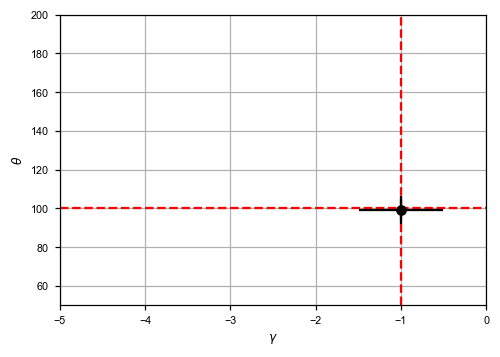

In [44]:
plt.axvline(-1,color='red',ls='--'); plt.axhline(100,color='red',ls='--'); plt.grid(); plt.ylim((50,200))
plt.errorbar(np.mean(estpar[:,0]),np.mean(estpar[:,1]),xerr=np.std(estpar[:,0]),yerr=np.std(estpar[:,1]),fmt='ko'); plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\theta$'); plt.xlim((-5,0));

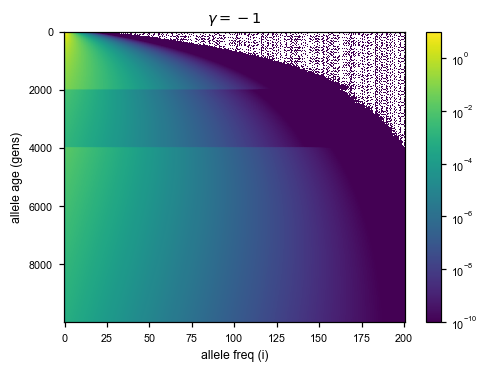

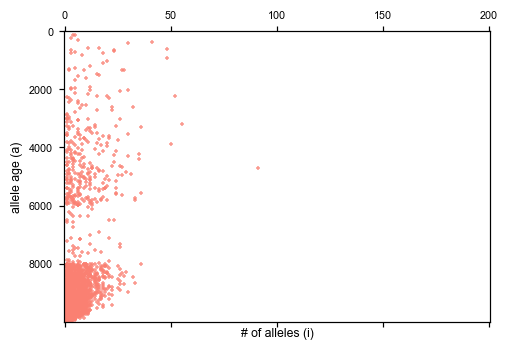

In [77]:
## simulate data for slightly more complex scenario: single gamma, bottleneck theta with **GIVEN** changepoints
# need a way to manipulate the run_mom_iterate internal values (using a specific theta model)
# plot what the expected fsa & SMSmask look like (do 10x increase)
theta = np.repeat(2000,10000); theta[2000:4000] = 200
fsa = run_mom_iterate_theta(10000, 200, -10/10000, 10000, theta, {})
plt.imshow(fsa[::-1], aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.title(r'$\gamma = -1$'); plt.xlabel('allele freq (i)'); plt.ylabel('allele age (gens)'); plt.colorbar(); plt.show()
mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask[::-1],aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

In [204]:
sp.optimize.minimize(get_ll_theta_bottleneck,x0=np.log10([10,5,20]),method='L-BFGS-B',args=({'sms':SMSmask,'N':10000,'gens':10000,'changept1':2000,'changept2':4000},200),bounds=((-3,3),(0,4),(0,4)))
# np.sqrt(np.diag(B.hess_inv.todense()))
# get_ll_theta_bottleneck(np.log10([1,250,5000]),{'sms':SMSmask,'N':10000,'gens':10000,'changept1':200,'changept2':400})

      fun: 2438.4940795750167
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.870, 2.328, -2.583])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 8
     njev: 23
   status: 0
  success: True
        x: array([-0.195, 2.041, 1.629])

In [ ]:
# def optim_func(x0):
#     return sp.optimize.minimize(get_ll_theta_bottleneck,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-1,3),(0,4),(0,4),(0,4),(1,4)))
# get_ll_theta_bottleneck(np.log10([10,2000,200,2000,2000]),{'sms':SMSmask,'N':10000,'gens':10000})
# x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6), np.random.uniform(1,4,6)))
# finalres = Parallel(n_jobs=2)(delayed(optim_func)(x) for x in x_init[:,:2].T)
# sp.optimize.minimize(get_ll_theta_bottleneck,x0=[1,3,2,3,3],method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-1,3),(0,4),(0,4),(0,4),(1,4)))
# estpar = np.zeros((nsims,4))
# for n in range(nsims):
#     SMS = np.zeros_like(fsa)
#     for i in range(1,SMS.shape[0]):
#         for j in range(1,SMS.shape[1]):
#             SMS[i,j] = rng.poisson(fsa[-i,j],1)
#     SMSmask = np.ma.array(SMS,mask=mask)

#     x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6)))
#     finalres = Parallel(n_jobs=6)(delayed(optim_func)(x) for x in x_init.T)
#     estpar[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
#     print(estpar[n,])

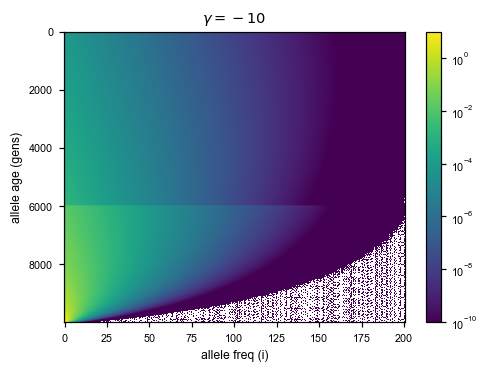

In [56]:
## simulate data for slightly more complex scenario: single gamma, two epoch theta with unknown changepoint
# theta = np.repeat(2000,10000); theta[4000:] = 200
# fsa = run_mom_iterate_theta(10000, 200, -10/10000, 10000, theta, {})
plt.imshow(fsa, aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.title(r'$\gamma = -10$'); plt.xlabel('allele freq (i)'); plt.ylabel('allele age (gens)'); plt.colorbar()
# SMS = np.zeros_like(fsa)
# mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
# for i in range(1,SMS.shape[0]):
#     for j in range(1,SMS.shape[1]):
#         SMS[i,j] = rng.poisson(fsa[-i,j],1)
# SMSmask = np.ma.array(SMS,mask=mask)
# plt.spy(SMSmask[::-1],aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()
# SMSmask.sum()

In [83]:
# tempres = sp.optimize.minimize(get_ll_theta_twoepoch,x0=np.log10([2,40,600,5000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# get_ll_theta_twoepoch(np.log10([2,200,1000,400]),{'sms':SMSmask,'N':10000,'gens':10000})
# def optim_func(x0):
#     return sp.optimize.minimize(get_ll_theta_twoepoch,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# estpar = np.zeros((nsims,4))
# for n in range(nsims):
#     SMS = np.zeros_like(fsa)
#     for i in range(1,SMS.shape[0]):
#         for j in range(1,SMS.shape[1]):
#             SMS[i,j] = rng.poisson(fsa[-i,j],1)
#     SMSmask = np.ma.array(SMS,mask=mask)

#     x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6)))
#     finalres = Parallel(n_jobs=6)(delayed(optim_func)(x) for x in x_init.T)
#     estpar[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
#     print(estpar[n,])

ERROR! Session/line number was not unique in database. History logging moved to new session 219


In [73]:
## what if we think there is only one mutation rate? 
# finalres[2].fun, sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))
# Parallel(n_jobs=4)(delayed(optim_func)(x) for x in x_init.T), sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))

In [74]:
# estpar[10,] = [9.859, 2048.652, 195.156, 3989.037]
# plt.violinplot(estpar[:11,]); plt.semilogy(); plt.axhline(10,color='red',ls='--'); plt.axhline(2000,color='red',ls='--'); plt.axhline(200,color='red',ls='--'); plt.axhline(4000,color='red',ls='--'); plt.xticks(range(1,5),labels=[r'$\gamma$',r'$\theta_1$',r'$\theta_2$','changepoint']) 
# np.percentile(estpar,[5,95],axis=0)
# sp.optimize.minimize(get_ll_theta_twoepoch,x0=[1.5,3.5,1.6,3],method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# from joblib import Parallel, delayed
# finalres = Parallel(n_jobs=6)(delayed(my_func)(x) for x in x_init.T)
# 10**finalres[np.argmin([i.fun for i in finalres])].x